## metricas modelo sem fine tuning

In [1]:
import torch
import nltk
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from tqdm import tqdm

nltk.download("punkt")

rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")

model_name = "unicamp-dl/ptt5-v2-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Dispositivo selecionado: {device}")
if torch.cuda.is_available():
    print(f"🚀 GPU disponível: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memória GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU não disponível, usando CPU")

model = model.to(device)
print(f"✅ Modelo carregado no dispositivo: {next(model.parameters()).device}")

dataset = load_dataset("recogna-nlp/recognasumm", split="test")
dataset = dataset.rename_column("Noticia", "text")
dataset = dataset.rename_column("Sumario", "summary")
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["text", "summary"]])

batch_size = 16
max_input_len = 512
max_output_len = 150

all_preds_texts = []
all_labels_texts = []
empty_predictions = 0

print(f"Processando {len(dataset)} exemplos do split de teste...")

for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i:i+batch_size]

    texts_with_prefix = ["summarize: " + text for text in batch["text"]]

    inputs = tokenizer(
        texts_with_prefix,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_input_len
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_output_len,
            min_length=5,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            num_beams=3,
            length_penalty=1.0,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["summary"]

    for pred, label in zip(preds, labels):
        pred = pred.strip()
        if not pred:
            empty_predictions += 1
            continue

        all_preds_texts.append(pred)
        all_labels_texts.append(label)


print(f"\n=== DIAGNÓSTICO ===")
print(f"Predições vazias encontradas: {empty_predictions}")
print(f"Total de exemplos válidos para avaliação: {len(all_preds_texts)}")
print(f"Exemplos excluídos da avaliação: {empty_predictions}")
print(f"Taxa de sucesso do modelo: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")


rouge_result = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_l_val = round(rouge_result["rougeL"], 3)

rouge_scores_per_example = []
for pred, ref in zip(all_preds_texts, all_labels_texts):
    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_scores_per_example.append(score["rougeL"])

rouge_l_std = round(np.std(rouge_scores_per_example), 3)

bertscore_result = bertscore_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    lang="pt"
)
bertscore_f1s = bertscore_result["f1"]

bertscore_mean = round(np.mean(bertscore_f1s), 3)
bertscore_std = round(np.std(bertscore_f1s), 3)

print("\n=== EXEMPLOS DE PREDIÇÕES ===")
for i in range(min(3, len(all_preds_texts))):
    print(f"\nExemplo {i+1}:")
    print(f"Texto original: {dataset[i]['text'][:100]}...")
    print(f"Referência: {all_labels_texts[i]}")
    print(f"Predição: {all_preds_texts[i]}")
    print("-" * 50)


print("\n=== MÉTRICAS (APENAS PREDIÇÕES VÁLIDAS) ===")
print(f"ROUGE-L: {rouge_l_val} ± {rouge_l_std}")
print(f"BERTScore F1: {bertscore_mean} ± {bertscore_std}")
print(f"Exemplos válidos avaliados: {len(all_preds_texts)}")
print(f"Exemplos com predições vazias (excluídos): {empty_predictions}")
print(f"Taxa de sucesso na geração: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")

[nltk_data] Error loading punkt: <urlopen error [WinError 10054] Foi
[nltk_data]     forçado o cancelamento de uma conexão existente pelo
[nltk_data]     host remoto>
C:\Users\mathe\PycharmProjects\PlnProjeto\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


🔧 Dispositivo selecionado: cuda
🚀 GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memória GPU: 6.0 GB
✅ Modelo carregado no dispositivo: cuda:0
Processando 27055 exemplos do split de teste...


100%|██████████| 1691/1691 [1:52:00<00:00,  3.97s/it]



=== DIAGNÓSTICO ===
Predições vazias encontradas: 1
Total de exemplos válidos para avaliação: 27054
Exemplos excluídos da avaliação: 1
Taxa de sucesso do modelo: 100.00%

=== EXEMPLOS DE PREDIÇÕES ===

Exemplo 1:
Texto original: “O que impressiona, fundamentalmente, é o conjunto da obra. Percebendo-se qual foi a ideia central, ...
Referência: Relatório à CPI mostra que Bolsonaro conspirou contra a Saúde, diz Reale Jr. Jurista e ex-ministro da Justiça – um dos autores do pedido de impeachment de Dilma Rousseff – diz que ações do presidente não foram por negligência, mas sim por 'projeto de desconsideração da vida e da saúde'
Predição: de Mandetta e de Mandetta.” Leia Mais No parecer de 230 páginas, os especialistas citam ainda outros possíveis crimes cometidos por Bolsonaro, como o crime de epidemia, e o crime de epidemia.,,,,..,.....” Leia Mais No parecer de 230 páginas, reale Júnior cita o presidente Bolsonaro
--------------------------------------------------

Exemplo 2:
Texto origi

In [4]:


import evaluate
import numpy as np

bleu_metric = evaluate.load("bleu")

print("📊 Calculando métricas adicionais...")
print(f"Avaliando {len(all_preds_texts)} predições válidas...")
print("⏳ Iniciando cálculo das métricas...")

rouge_detailed = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_1_val = round(rouge_detailed["rouge1"], 3)
rouge_2_val = round(rouge_detailed["rouge2"], 3)

rouge_1_scores = []
rouge_2_scores = []

print("📊 Calculando ROUGE-1 e ROUGE-2 por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 100 == 0:
        progress = (i / len(all_preds_texts)) * 100
        print(f"   Progresso ROUGE: {progress:.1f}% ({i}/{len(all_preds_texts)})")

    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_1_scores.append(score["rouge1"])
    rouge_2_scores.append(score["rouge2"])

rouge_1_std = round(np.std(rouge_1_scores), 3)
rouge_2_std = round(np.std(rouge_2_scores), 3)
print("✅ ROUGE-1 e ROUGE-2 calculados!")

bleu_result = bleu_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts
)

bleu_val = round(bleu_result["bleu"], 3)

bleu_scores = []
print("📊 Calculando BLEU por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 100 == 0:  # Atualiza a cada 100 exemplos
        progress = (i / len(all_preds_texts)) * 100
        print(f"   Progresso BLEU: {progress:.1f}% ({i}/{len(all_preds_texts)})")

    try:
        score = bleu_metric.compute(predictions=[pred], references=[ref])
        bleu_scores.append(score["bleu"])
    except:
        bleu_scores.append(0.0)

bleu_std = round(np.std(bleu_scores), 3)
print("✅ BLEU calculado!")

print("\n" + "="*50)
print("📈 TODAS AS MÉTRICAS DE AVALIAÇÃO")
print("="*50)
print(f"ROUGE-1:     {rouge_1_val} ± {rouge_1_std}")
print(f"ROUGE-2:     {rouge_2_val} ± {rouge_2_std}")
print(f"ROUGE-L:     {rouge_l_val} ± {rouge_l_std}")
print(f"BERTScore:   {bertscore_mean} ± {bertscore_std}")
print(f"BLEU:        {bleu_val} ± {bleu_std}")
print("="*50)
print(f"📊 Estatísticas:")
print(f"   • Exemplos válidos: {len(all_preds_texts)}")
print(f"   • Predições vazias: {empty_predictions}")
print(f"   • Taxa de sucesso: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")
print("="*50)


print("\n📋 INTERPRETAÇÃO DAS MÉTRICAS:")
print("• ROUGE-1: Sobreposição de unigramas (palavras individuais)")
print("• ROUGE-2: Sobreposição de bigramas (pares de palavras)")
print("• ROUGE-L: Maior subsequência comum (ordem das palavras)")
print("• BERTScore: Similaridade semântica usando embeddings")
print("• BLEU: Métrica tradicional de tradução automática")


print("\n📋 RESUMO EM FORMATO TABULAR:")
print("┌─────────────┬─────────┬─────────┐")
print("│ Métrica     │ Valor   │ Desvio  │")
print("├─────────────┼─────────┼─────────┤")
print(f"│ ROUGE-1     │ {rouge_1_val:>7} │ {rouge_1_std:>7} │")
print(f"│ ROUGE-2     │ {rouge_2_val:>7} │ {rouge_2_std:>7} │")
print(f"│ ROUGE-L     │ {rouge_l_val:>7} │ {rouge_l_std:>7} │")
print(f"│ BERTScore   │ {bertscore_mean:>7} │ {bertscore_std:>7} │")
print(f"│ BLEU        │ {bleu_val:>7} │ {bleu_std:>7} │")
print("└─────────────┴─────────┴─────────┘")

📊 Calculando métricas adicionais...
Avaliando 27054 predições válidas...
⏳ Iniciando cálculo das métricas...
📊 Calculando ROUGE-1 e ROUGE-2 por exemplo...
   Progresso ROUGE: 0.0% (0/27054)
   Progresso ROUGE: 0.4% (100/27054)
   Progresso ROUGE: 0.7% (200/27054)
   Progresso ROUGE: 1.1% (300/27054)
   Progresso ROUGE: 1.5% (400/27054)
   Progresso ROUGE: 1.8% (500/27054)
   Progresso ROUGE: 2.2% (600/27054)
   Progresso ROUGE: 2.6% (700/27054)
   Progresso ROUGE: 3.0% (800/27054)
   Progresso ROUGE: 3.3% (900/27054)
   Progresso ROUGE: 3.7% (1000/27054)
   Progresso ROUGE: 4.1% (1100/27054)
   Progresso ROUGE: 4.4% (1200/27054)
   Progresso ROUGE: 4.8% (1300/27054)
   Progresso ROUGE: 5.2% (1400/27054)
   Progresso ROUGE: 5.5% (1500/27054)
   Progresso ROUGE: 5.9% (1600/27054)
   Progresso ROUGE: 6.3% (1700/27054)
   Progresso ROUGE: 6.7% (1800/27054)
   Progresso ROUGE: 7.0% (1900/27054)
   Progresso ROUGE: 7.4% (2000/27054)
   Progresso ROUGE: 7.8% (2100/27054)
   Progresso ROUGE: 8

## metricas checkpoint modelo

In [1]:
import torch
import nltk
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from tqdm import tqdm
import os
import json

nltk.download("punkt")

rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")

checkpoint_path = "checkpoint-3125"

print("📁 Arquivos encontrados no checkpoint:")
if os.path.exists(checkpoint_path):
    for file in os.listdir(checkpoint_path):
        print(f"  - {file}")
else:
    print(f"❌ Caminho não encontrado: {checkpoint_path}")
    exit()

def load_model_and_tokenizer(checkpoint_path):
    try:
        from peft import PeftModel, PeftConfig

        config = PeftConfig.from_pretrained(checkpoint_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)

        model = PeftModel.from_pretrained(base_model, checkpoint_path)

        tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

        print("✅ Model loaded successfully with PEFT")
        return model, tokenizer

    except ImportError:
        print("⚠️  PEFT not available, loading base model only")

        model_name = "your-base-model-name"
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        return model, tokenizer

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

from peft import PeftModel
import peft

try:
    with open(os.path.join(checkpoint_path, "adapter_config.json"), "r") as f:
        adapter_config = json.load(f)

    base_model_name = adapter_config.get("base_model_name_or_path", "unicamp-dl/ptt5-v2-small")
    print(f"🔍 Modelo base detectado: {base_model_name}")

    print("🔄 Carregando modelo base...")
    base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

    print("🔄 Carregando tokenizer...")
    if os.path.exists(os.path.join(checkpoint_path, "tokenizer.json")):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
        print("✅ Tokenizer carregado do checkpoint")
    else:
        tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        print("✅ Tokenizer carregado do modelo base")

    print("🔄 Aplicando adaptadores LoRA...")
    model = PeftModel.from_pretrained(base_model, checkpoint_path)

    print("🔄 Mesclando adaptadores com modelo base...")
    model = model.merge_and_unload()

    print("✅ Modelo LoRA carregado e mesclado com sucesso!")

except Exception as e:
    print(f"❌ Erro ao carregar modelo LoRA: {e}")
    print("\n🔧 Dicas de solução:")
    print("1. Verifique se o caminho está correto")
    print("2. Instale a biblioteca PEFT: pip install peft")
    print("3. Verifique se adapter_config.json e adapter_model.safetensors existem")
    exit()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


📁 Arquivos encontrados no checkpoint:
  - adapter_config.json
  - adapter_model.safetensors
  - optimizer.pt
  - README.md
  - rng_state.pth
  - scheduler.pt
  - special_tokens_map.json
  - spiece.model
  - tokenizer.json
  - tokenizer_config.json
  - trainer_state.json
  - training_args.bin
🔍 Modelo base detectado: unicamp-dl/ptt5-v2-small
🔄 Carregando modelo base...
🔄 Carregando tokenizer...
✅ Tokenizer carregado do checkpoint
🔄 Aplicando adaptadores LoRA...
🔄 Mesclando adaptadores com modelo base...
✅ Modelo LoRA carregado e mesclado com sucesso!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Dispositivo selecionado: {device}")
if torch.cuda.is_available():
    print(f"🚀 GPU disponível: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memória GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU não disponível, usando CPU")

model = model.to(device)
print(f"✅ Modelo carregado no dispositivo: {next(model.parameters()).device}")



🔧 Dispositivo selecionado: cuda
🚀 GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memória GPU: 6.0 GB
✅ Modelo carregado no dispositivo: cuda:0


In [3]:

dataset = load_dataset("recogna-nlp/recognasumm", split="test")
dataset = dataset.rename_column("Noticia", "text")
dataset = dataset.rename_column("Sumario", "summary")
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["text", "summary"]])

batch_size = 16
max_input_len = 512
max_output_len = 150

all_preds_texts = []
all_labels_texts = []
empty_predictions = 0

print(f"Processando {len(dataset)} exemplos do split de teste...")


Processando 27055 exemplos do split de teste...


In [4]:
for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i:i+batch_size]

    texts_with_prefix = ["summarize: " + text for text in batch["text"]]

    inputs = tokenizer(
        texts_with_prefix,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_input_len
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_output_len,
            min_length=5,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            num_beams=3,
            length_penalty=1.0,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["summary"]

    for pred, label in zip(preds, labels):
        pred = pred.strip()
        if not pred:
            empty_predictions += 1
            continue

        all_preds_texts.append(pred)
        all_labels_texts.append(label)


100%|██████████| 1691/1691 [56:00<00:00,  1.99s/it]


In [5]:

print(f"\n=== DIAGNÓSTICO ===")
print(f"Predições vazias encontradas: {empty_predictions}")
print(f"Total de exemplos válidos para avaliação: {len(all_preds_texts)}")
print(f"Exemplos excluídos da avaliação: {empty_predictions}")
print(f"Taxa de sucesso do modelo: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")


print("\n🔵 Calculando ROUGE-L...")
rouge_result = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_l_val = round(rouge_result["rougeL"], 3)

print("📊 Calculando desvio padrão ROUGE-L por exemplo...")
rouge_scores_per_example = []
total_examples = len(all_preds_texts)

for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 100 == 0 or i == total_examples - 1:
        progress = ((i + 1) / total_examples) * 100
        print(f"   Progresso ROUGE-L: {progress:.1f}% ({i+1}/{total_examples})")

    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_scores_per_example.append(score["rougeL"])

rouge_l_std = round(np.std(rouge_scores_per_example), 3)
print("✅ ROUGE-L calculado!")


print("\n🟢 Calculando BERTScore...")
bertscore_result = bertscore_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    lang="pt"
)
bertscore_f1s = bertscore_result["f1"]

bertscore_mean = round(np.mean(bertscore_f1s), 3)
bertscore_std = round(np.std(bertscore_f1s), 3)
print("✅ BERTScore calculado!")


print("\n=== EXEMPLOS DE PREDIÇÕES ===")
for i in range(min(3, len(all_preds_texts))):
    print(f"\nExemplo {i+1}:")
    print(f"Texto original: {dataset[i]['text'][:100]}...")
    print(f"Referência: {all_labels_texts[i]}")
    print(f"Predição: {all_preds_texts[i]}")
    print("-" * 50)


bleu_metric = evaluate.load("bleu")

print("\n📊 Calculando métricas adicionais...")
print(f"Avaliando {len(all_preds_texts)} predições válidas...")


print("\n🔵 Calculando ROUGE-1 e ROUGE-2 (agregado)...")
rouge_detailed = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_1_val = round(rouge_detailed["rouge1"], 3)
rouge_2_val = round(rouge_detailed["rouge2"], 3)

rouge_1_scores = []
rouge_2_scores = []

print("📊 Calculando desvio padrão ROUGE-1 e ROUGE-2 por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 50 == 0 or i == len(all_preds_texts) - 1:  # Atualiza a cada 50 exemplos
        progress = ((i + 1) / len(all_preds_texts)) * 100
        print(f"   Progresso ROUGE 1&2: {progress:.1f}% ({i+1}/{len(all_preds_texts)})")

    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_1_scores.append(score["rouge1"])
    rouge_2_scores.append(score["rouge2"])

rouge_1_std = round(np.std(rouge_1_scores), 3)
rouge_2_std = round(np.std(rouge_2_scores), 3)
print("✅ ROUGE-1 e ROUGE-2 calculados!")


print("\n🟡 Calculando BLEU (agregado)...")
bleu_result = bleu_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts
)

bleu_val = round(bleu_result["bleu"], 3)

bleu_scores = []
print("📊 Calculando desvio padrão BLEU por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 50 == 0 or i == len(all_preds_texts) - 1:
        progress = ((i + 1) / len(all_preds_texts)) * 100
        print(f"   Progresso BLEU: {progress:.1f}% ({i+1}/{len(all_preds_texts)})")

    try:
        score = bleu_metric.compute(predictions=[pred], references=[ref])
        bleu_scores.append(score["bleu"])
    except:
        bleu_scores.append(0.0)

bleu_std = round(np.std(bleu_scores), 3)
print("✅ BLEU calculado!")

print("\n" + "="*50)
print("📈 TODAS AS MÉTRICAS DE AVALIAÇÃO")
print("="*50)
print(f"ROUGE-1:     {rouge_1_val} ± {rouge_1_std}")
print(f"ROUGE-2:     {rouge_2_val} ± {rouge_2_std}")
print(f"ROUGE-L:     {rouge_l_val} ± {rouge_l_std}")
print(f"BERTScore:   {bertscore_mean} ± {bertscore_std}")
print(f"BLEU:        {bleu_val} ± {bleu_std}")
print("="*50)
print(f"📊 Estatísticas:")
print(f"   • Exemplos válidos: {len(all_preds_texts)}")
print(f"   • Predições vazias: {empty_predictions}")
print(f"   • Taxa de sucesso: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")
print("="*50)


print("\n📋 INTERPRETAÇÃO DAS MÉTRICAS:")
print("• ROUGE-1: Sobreposição de unigramas (palavras individuais)")
print("• ROUGE-2: Sobreposição de bigramas (pares de palavras)")
print("• ROUGE-L: Maior subsequência comum (ordem das palavras)")
print("• BERTScore: Similaridade semântica usando embeddings")
print("• BLEU: Métrica tradicional de tradução automática")


print("\n📋 RESUMO EM FORMATO TABULAR:")
print("┌─────────────┬─────────┬─────────┐")
print("│ Métrica     │ Valor   │ Desvio  │")
print("├─────────────┼─────────┼─────────┤")
print(f"│ ROUGE-1     │ {rouge_1_val:>7} │ {rouge_1_std:>7} │")
print(f"│ ROUGE-2     │ {rouge_2_val:>7} │ {rouge_2_std:>7} │")
print(f"│ ROUGE-L     │ {rouge_l_val:>7} │ {rouge_l_std:>7} │")
print(f"│ BERTScore   │ {bertscore_mean:>7} │ {bertscore_std:>7} │")
print(f"│ BLEU        │ {bleu_val:>7} │ {bleu_std:>7} │")
print("└─────────────┴─────────┴─────────┘")


print(f"\n=== INFORMAÇÕES DO MODELO ===")
print(f"Modelo base: {base_model_name}")
print(f"Checkpoint LoRA: {checkpoint_path}")
print(f"Adaptadores mesclados: ✅")
print(f"Dispositivo: {device}")
print("✅ Avaliação concluída!")


=== DIAGNÓSTICO ===
Predições vazias encontradas: 0
Total de exemplos válidos para avaliação: 27055
Exemplos excluídos da avaliação: 0
Taxa de sucesso do modelo: 100.00%

🔵 Calculando ROUGE-L...
📊 Calculando desvio padrão ROUGE-L por exemplo...
   Progresso ROUGE-L: 0.0% (1/27055)
   Progresso ROUGE-L: 0.4% (101/27055)
   Progresso ROUGE-L: 0.7% (201/27055)
   Progresso ROUGE-L: 1.1% (301/27055)
   Progresso ROUGE-L: 1.5% (401/27055)
   Progresso ROUGE-L: 1.9% (501/27055)
   Progresso ROUGE-L: 2.2% (601/27055)
   Progresso ROUGE-L: 2.6% (701/27055)
   Progresso ROUGE-L: 3.0% (801/27055)
   Progresso ROUGE-L: 3.3% (901/27055)
   Progresso ROUGE-L: 3.7% (1001/27055)
   Progresso ROUGE-L: 4.1% (1101/27055)
   Progresso ROUGE-L: 4.4% (1201/27055)
   Progresso ROUGE-L: 4.8% (1301/27055)
   Progresso ROUGE-L: 5.2% (1401/27055)
   Progresso ROUGE-L: 5.5% (1501/27055)
   Progresso ROUGE-L: 5.9% (1601/27055)
   Progresso ROUGE-L: 6.3% (1701/27055)
   Progresso ROUGE-L: 6.7% (1801/27055)
   Pro

## plotando as métricas

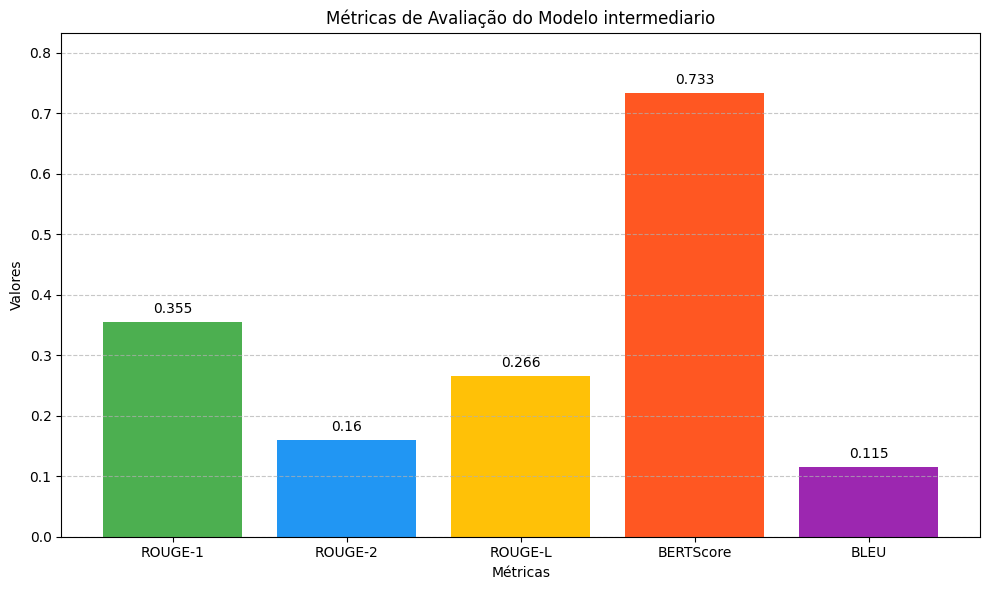

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
metrics = {
    "ROUGE-1": rouge_1_val,
    "ROUGE-2": rouge_2_val,
    "ROUGE-L": rouge_l_val,
    "BERTScore": bertscore_mean,
    "BLEU": bleu_val
}
values = list(metrics.values())
labels = list(metrics.keys())
plt.bar(labels, values, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])
plt.title('Métricas de Avaliação do Modelo intermediario')
plt.xlabel('Métricas')
plt.ylabel('Valores')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')
plt.ylim(0, max(values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

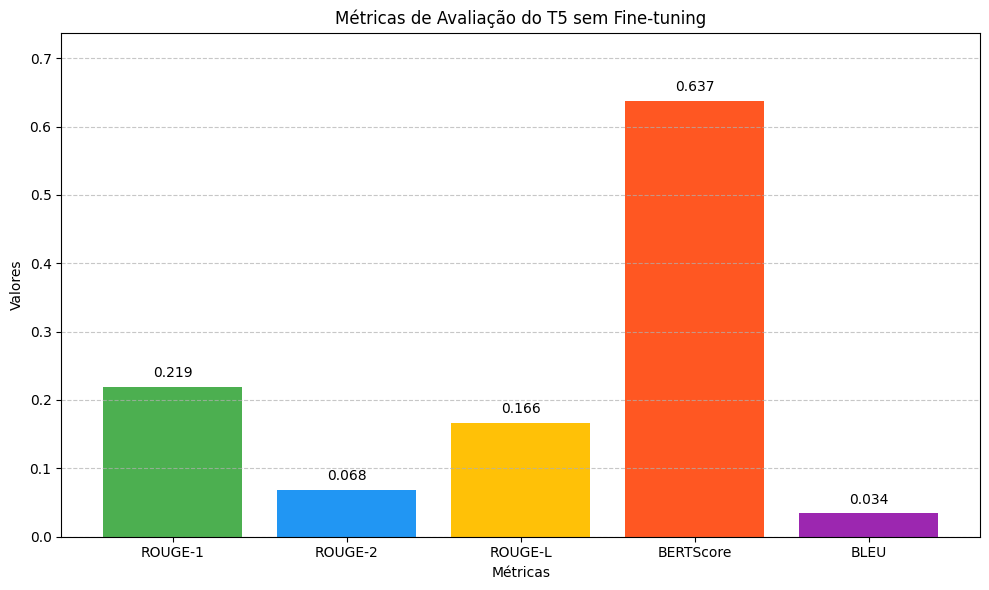

In [8]:
t5_sem_ft = {
    "ROUGE-1": 0.219,
    "ROUGE-2": 0.068,
    "ROUGE-L": 0.166,
    "BERTScore": 0.637,
    "BLEU": 0.034
}


plt.figure(figsize=(10, 6))

values_sem_ft = list(t5_sem_ft.values())
labels = list(t5_sem_ft.keys())

plt.bar(labels, values_sem_ft, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])

plt.title('Métricas de Avaliação do T5 sem Fine-tuning')
plt.xlabel('Métricas')
plt.ylabel('Valores')

for i, v in enumerate(values_sem_ft):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.ylim(0, max(values_sem_ft) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

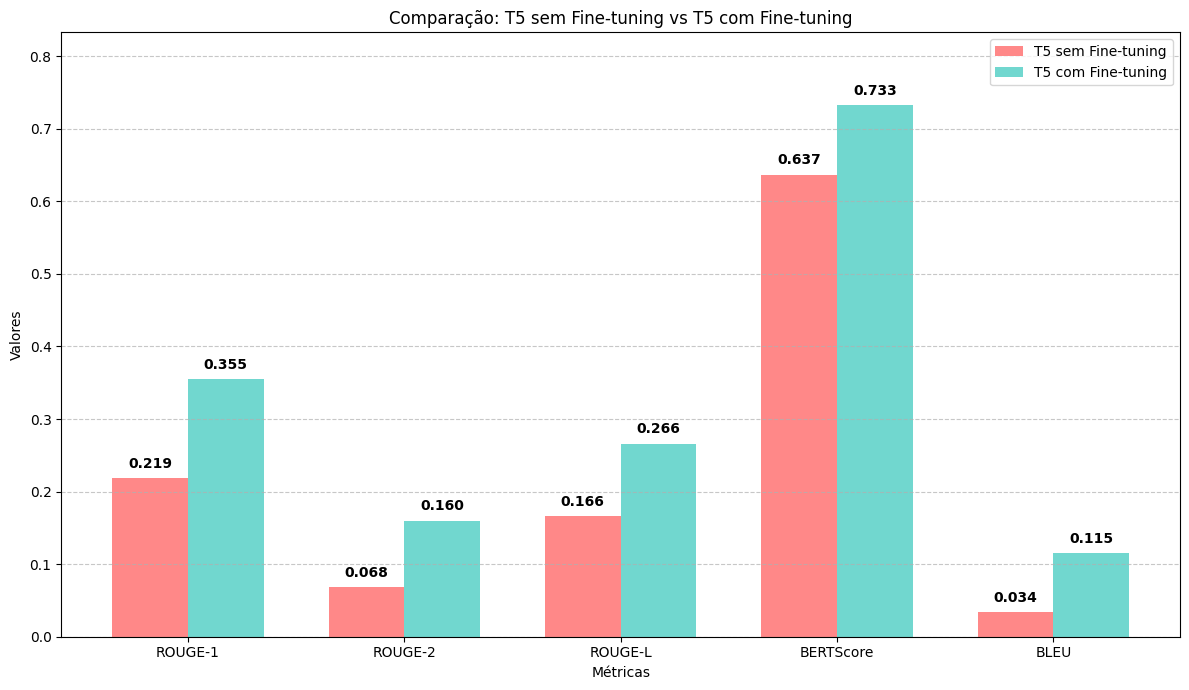

In [9]:
plt.figure(figsize=(12, 7))

metrics_com_ft = {
    "ROUGE-1": rouge_1_val,
    "ROUGE-2": rouge_2_val,
    "ROUGE-L": rouge_l_val,
    "BERTScore": bertscore_mean,
    "BLEU": bleu_val
}

values_com_ft = list(metrics_com_ft.values())
values_sem_ft = list(t5_sem_ft.values())
labels = list(metrics_com_ft.keys())

x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width/2, values_sem_ft, width, label='T5 sem Fine-tuning',
                color='#FF6B6B', alpha=0.8)
bars2 = plt.bar(x + width/2, values_com_ft, width, label='T5 com Fine-tuning',
                color='#4ECDC4', alpha=0.8)

plt.title('Comparação: T5 sem Fine-tuning vs T5 com Fine-tuning')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.xticks(x, labels)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.legend()
plt.ylim(0, max(max(values_sem_ft), max(values_com_ft)) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
print("="*70)
print("COMPARAÇÃO T5 SEM FINE-TUNING vs COM FINE-TUNING")
print("="*70)
print(f"{'Métrica':<12} {'Sem FT':<10} {'Com FT':<10} {'Diferença':<12} {'Melhoria %':<12}")
print("-"*70)

for metric in labels:
    sem_ft = t5_sem_ft[metric]
    com_ft_val = metrics_com_ft[metric]
    diferenca = com_ft_val - sem_ft
    melhoria = (diferenca / sem_ft) * 100 if sem_ft != 0 else 0

    print(f"{metric:<12} {sem_ft:<10.3f} {com_ft_val:<10.3f} {diferenca:<12.3f} {melhoria:<12.1f}%")

print("="*70)

COMPARAÇÃO T5 SEM FINE-TUNING vs COM FINE-TUNING
Métrica      Sem FT     Com FT     Diferença    Melhoria %  
----------------------------------------------------------------------
ROUGE-1      0.219      0.355      0.136        62.1        %
ROUGE-2      0.068      0.160      0.092        135.3       %
ROUGE-L      0.166      0.266      0.100        60.2        %
BERTScore    0.637      0.733      0.096        15.1        %
BLEU         0.034      0.115      0.081        238.2       %


## metricas modelo final

In [11]:
nltk.download("punkt")

rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")

checkpoint_path = "ptt5_v2_small_qlora"
print("📁 Arquivos encontrados no checkpoint:")
if os.path.exists(checkpoint_path):
    for file in os.listdir(checkpoint_path):
        print(f"  - {file}")
else:
    print(f"❌ Caminho não encontrado: {checkpoint_path}")
    exit()

def load_model_and_tokenizer(checkpoint_path):

    try:
        from peft import PeftModel, PeftConfig

        config = PeftConfig.from_pretrained(checkpoint_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)

        model = PeftModel.from_pretrained(base_model, checkpoint_path)

        tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

        print("✅ Model loaded successfully with PEFT")
        return model, tokenizer

    except ImportError:
        print("⚠️  PEFT not available, loading base model only")
        model_name = "your-base-model-name"
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        return model, tokenizer

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

from peft import PeftModel
import peft

try:
    with open(os.path.join(checkpoint_path, "adapter_config.json"), "r") as f:
        adapter_config = json.load(f)

    base_model_name = adapter_config.get("base_model_name_or_path", "unicamp-dl/ptt5-v2-small")
    print(f"🔍 Modelo base detectado: {base_model_name}")

    print("🔄 Carregando modelo base...")
    base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

    print("🔄 Carregando tokenizer...")
    if os.path.exists(os.path.join(checkpoint_path, "tokenizer.json")):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
        print("✅ Tokenizer carregado do checkpoint")
    else:
        tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        print("✅ Tokenizer carregado do modelo base")

    print("🔄 Aplicando adaptadores LoRA...")
    model = PeftModel.from_pretrained(base_model, checkpoint_path)

    print("🔄 Mesclando adaptadores com modelo base...")
    model = model.merge_and_unload()

    print("✅ Modelo LoRA carregado e mesclado com sucesso!")

except Exception as e:
    print(f"❌ Erro ao carregar modelo LoRA: {e}")
    print("\n🔧 Dicas de solução:")
    print("1. Verifique se o caminho está correto")
    print("2. Instale a biblioteca PEFT: pip install peft")
    print("3. Verifique se adapter_config.json e adapter_model.safetensors existem")
    exit()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


📁 Arquivos encontrados no checkpoint:
  - adapter_config.json
  - adapter_model.safetensors
  - README.md
  - special_tokens_map.json
  - spiece.model
  - tokenizer.json
  - tokenizer_config.json
  - training_args.bin
🔍 Modelo base detectado: unicamp-dl/ptt5-v2-small
🔄 Carregando modelo base...
🔄 Carregando tokenizer...
✅ Tokenizer carregado do checkpoint
🔄 Aplicando adaptadores LoRA...
🔄 Mesclando adaptadores com modelo base...
✅ Modelo LoRA carregado e mesclado com sucesso!


In [12]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Dispositivo selecionado: {device}")
if torch.cuda.is_available():
    print(f"🚀 GPU disponível: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memória GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU não disponível, usando CPU")

model = model.to(device)
print(f"✅ Modelo carregado no dispositivo: {next(model.parameters()).device}")



🔧 Dispositivo selecionado: cuda
🚀 GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memória GPU: 6.0 GB
✅ Modelo carregado no dispositivo: cuda:0


In [13]:

dataset = load_dataset("recogna-nlp/recognasumm", split="test")
dataset = dataset.rename_column("Noticia", "text")
dataset = dataset.rename_column("Sumario", "summary")
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["text", "summary"]])

batch_size = 16
max_input_len = 512
max_output_len = 150

all_preds_texts = []
all_labels_texts = []
empty_predictions = 0

print(f"Processando {len(dataset)} exemplos do split de teste...")


Processando 27055 exemplos do split de teste...


In [14]:

for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i:i+batch_size]

    texts_with_prefix = ["summarize: " + text for text in batch["text"]]

    inputs = tokenizer(
        texts_with_prefix,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_input_len
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_output_len,
            min_length=5,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            num_beams=3,
            length_penalty=1.0,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["summary"]

    for pred, label in zip(preds, labels):
        pred = pred.strip()
        if not pred:
            empty_predictions += 1
            continue

        all_preds_texts.append(pred)
        all_labels_texts.append(label)


100%|██████████| 1691/1691 [1:00:30<00:00,  2.15s/it]


In [15]:

print(f"\n=== DIAGNÓSTICO ===")
print(f"Predições vazias encontradas: {empty_predictions}")
print(f"Total de exemplos válidos para avaliação: {len(all_preds_texts)}")
print(f"Exemplos excluídos da avaliação: {empty_predictions}")
print(f"Taxa de sucesso do modelo: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")


print("\n🔵 Calculando ROUGE-L...")
rouge_result = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_l_val = round(rouge_result["rougeL"], 3)

print("📊 Calculando desvio padrão ROUGE-L por exemplo...")
rouge_scores_per_example = []
total_examples = len(all_preds_texts)

for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 100 == 0 or i == total_examples - 1:
        progress = ((i + 1) / total_examples) * 100
        print(f"   Progresso ROUGE-L: {progress:.1f}% ({i+1}/{total_examples})")

    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_scores_per_example.append(score["rougeL"])

rouge_l_std = round(np.std(rouge_scores_per_example), 3)
print("✅ ROUGE-L calculado!")


print("\n🟢 Calculando BERTScore...")
bertscore_result = bertscore_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    lang="pt"
)
bertscore_f1s = bertscore_result["f1"]

bertscore_mean = round(np.mean(bertscore_f1s), 3)
bertscore_std = round(np.std(bertscore_f1s), 3)
print("✅ BERTScore calculado!")


print("\n=== EXEMPLOS DE PREDIÇÕES ===")
for i in range(min(3, len(all_preds_texts))):
    print(f"\nExemplo {i+1}:")
    print(f"Texto original: {dataset[i]['text'][:100]}...")
    print(f"Referência: {all_labels_texts[i]}")
    print(f"Predição: {all_preds_texts[i]}")
    print("-" * 50)


bleu_metric = evaluate.load("bleu")

print("\n📊 Calculando métricas adicionais...")
print(f"Avaliando {len(all_preds_texts)} predições válidas...")


print("\n🔵 Calculando ROUGE-1 e ROUGE-2 (agregado)...")
rouge_detailed = rouge_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts,
    use_stemmer=True
)

rouge_1_val = round(rouge_detailed["rouge1"], 3)
rouge_2_val = round(rouge_detailed["rouge2"], 3)

rouge_1_scores = []
rouge_2_scores = []

print("📊 Calculando desvio padrão ROUGE-1 e ROUGE-2 por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 50 == 0 or i == len(all_preds_texts) - 1:  # Atualiza a cada 50 exemplos
        progress = ((i + 1) / len(all_preds_texts)) * 100
        print(f"   Progresso ROUGE 1&2: {progress:.1f}% ({i+1}/{len(all_preds_texts)})")

    score = rouge_metric.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_1_scores.append(score["rouge1"])
    rouge_2_scores.append(score["rouge2"])

rouge_1_std = round(np.std(rouge_1_scores), 3)
rouge_2_std = round(np.std(rouge_2_scores), 3)
print("✅ ROUGE-1 e ROUGE-2 calculados!")


print("\n🟡 Calculando BLEU (agregado)...")
bleu_result = bleu_metric.compute(
    predictions=all_preds_texts,
    references=all_labels_texts
)

bleu_val = round(bleu_result["bleu"], 3)

bleu_scores = []
print("📊 Calculando desvio padrão BLEU por exemplo...")
for i, (pred, ref) in enumerate(zip(all_preds_texts, all_labels_texts)):
    if i % 50 == 0 or i == len(all_preds_texts) - 1:
        progress = ((i + 1) / len(all_preds_texts)) * 100
        print(f"   Progresso BLEU: {progress:.1f}% ({i+1}/{len(all_preds_texts)})")

    try:
        score = bleu_metric.compute(predictions=[pred], references=[ref])
        bleu_scores.append(score["bleu"])
    except:
        bleu_scores.append(0.0)

bleu_std = round(np.std(bleu_scores), 3)
print("✅ BLEU calculado!")


print("\n" + "="*50)
print("📈 TODAS AS MÉTRICAS DE AVALIAÇÃO")
print("="*50)
print(f"ROUGE-1:     {rouge_1_val} ± {rouge_1_std}")
print(f"ROUGE-2:     {rouge_2_val} ± {rouge_2_std}")
print(f"ROUGE-L:     {rouge_l_val} ± {rouge_l_std}")
print(f"BERTScore:   {bertscore_mean} ± {bertscore_std}")
print(f"BLEU:        {bleu_val} ± {bleu_std}")
print("="*50)
print(f"📊 Estatísticas:")
print(f"   • Exemplos válidos: {len(all_preds_texts)}")
print(f"   • Predições vazias: {empty_predictions}")
print(f"   • Taxa de sucesso: {(len(all_preds_texts)/(len(all_preds_texts)+empty_predictions))*100:.2f}%")
print("="*50)


print("\n📋 INTERPRETAÇÃO DAS MÉTRICAS:")
print("• ROUGE-1: Sobreposição de unigramas (palavras individuais)")
print("• ROUGE-2: Sobreposição de bigramas (pares de palavras)")
print("• ROUGE-L: Maior subsequência comum (ordem das palavras)")
print("• BERTScore: Similaridade semântica usando embeddings")
print("• BLEU: Métrica tradicional de tradução automática")


print("\n📋 RESUMO EM FORMATO TABULAR:")
print("┌─────────────┬─────────┬─────────┐")
print("│ Métrica     │ Valor   │ Desvio  │")
print("├─────────────┼─────────┼─────────┤")
print(f"│ ROUGE-1     │ {rouge_1_val:>7} │ {rouge_1_std:>7} │")
print(f"│ ROUGE-2     │ {rouge_2_val:>7} │ {rouge_2_std:>7} │")
print(f"│ ROUGE-L     │ {rouge_l_val:>7} │ {rouge_l_std:>7} │")
print(f"│ BERTScore   │ {bertscore_mean:>7} │ {bertscore_std:>7} │")
print(f"│ BLEU        │ {bleu_val:>7} │ {bleu_std:>7} │")
print("└─────────────┴─────────┴─────────┘")


print(f"\n=== INFORMAÇÕES DO MODELO ===")
print(f"Modelo base: {base_model_name}")
print(f"Checkpoint LoRA: {checkpoint_path}")
print(f"Adaptadores mesclados: ✅")
print(f"Dispositivo: {device}")
print("✅ Avaliação concluída!")


=== DIAGNÓSTICO ===
Predições vazias encontradas: 0
Total de exemplos válidos para avaliação: 27055
Exemplos excluídos da avaliação: 0
Taxa de sucesso do modelo: 100.00%

🔵 Calculando ROUGE-L...
📊 Calculando desvio padrão ROUGE-L por exemplo...
   Progresso ROUGE-L: 0.0% (1/27055)
   Progresso ROUGE-L: 0.4% (101/27055)
   Progresso ROUGE-L: 0.7% (201/27055)
   Progresso ROUGE-L: 1.1% (301/27055)
   Progresso ROUGE-L: 1.5% (401/27055)
   Progresso ROUGE-L: 1.9% (501/27055)
   Progresso ROUGE-L: 2.2% (601/27055)
   Progresso ROUGE-L: 2.6% (701/27055)
   Progresso ROUGE-L: 3.0% (801/27055)
   Progresso ROUGE-L: 3.3% (901/27055)
   Progresso ROUGE-L: 3.7% (1001/27055)
   Progresso ROUGE-L: 4.1% (1101/27055)
   Progresso ROUGE-L: 4.4% (1201/27055)
   Progresso ROUGE-L: 4.8% (1301/27055)
   Progresso ROUGE-L: 5.2% (1401/27055)
   Progresso ROUGE-L: 5.5% (1501/27055)
   Progresso ROUGE-L: 5.9% (1601/27055)
   Progresso ROUGE-L: 6.3% (1701/27055)
   Progresso ROUGE-L: 6.7% (1801/27055)
   Pro

### graficos das metricas

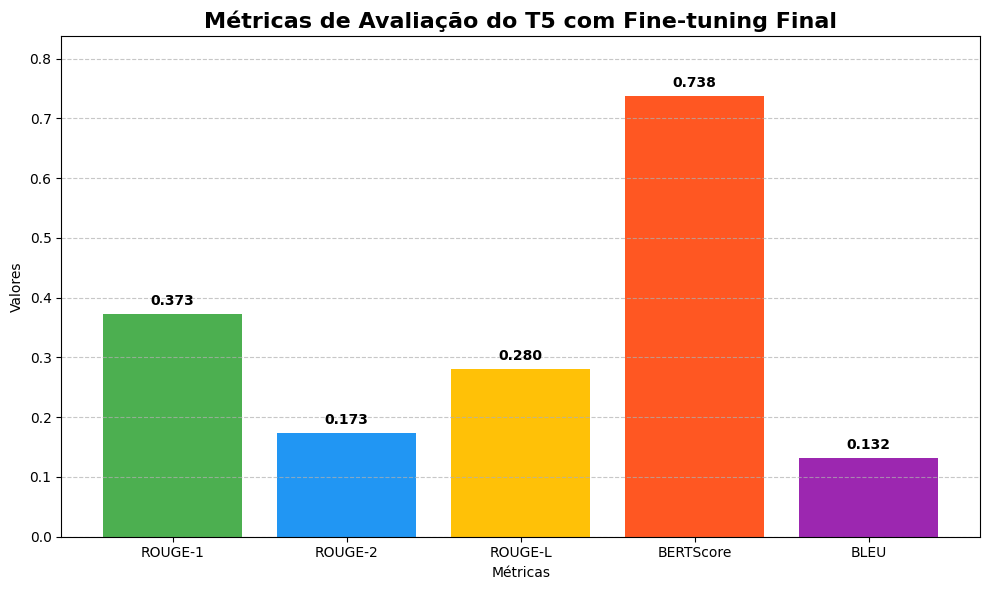

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# DADOS DOS TRÊS MODELOS
# ============================================================================

# T5 sem Fine-tuning
t5_sem_ft = {
    "ROUGE-1": 0.219,
    "ROUGE-2": 0.068,
    "ROUGE-L": 0.166,
    "BERTScore": 0.637,
    "BLEU": 0.034
}

# T5 com Fine-tuning Intermediário
t5_ft_intermediario = {
    "ROUGE-1": 0.355,
    "ROUGE-2": 0.160,
    "ROUGE-L": 0.266,
    "BERTScore": 0.733,
    "BLEU": 0.115
}

# T5 com Fine-tuning Final
t5_ft_final = {
    "ROUGE-1": 0.373,
    "ROUGE-2": 0.173,
    "ROUGE-L": 0.280,
    "BERTScore": 0.738,
    "BLEU": 0.132
}

# Desvios padrão
desvios_sem_ft = [0.121, 0.081, 0.092, 0.057, 0.051]
desvios_intermediario = [0.149, 0.147, 0.141, 0.058, 0.124]
desvios_final = [0.151, 0.156, 0.147, 0.060, 0.138]

# ============================================================================
# GRÁFICO 1: T5 com Fine-tuning Final (apenas)
# ============================================================================
plt.figure(figsize=(10, 6))

# Valores das métricas
values_final = list(t5_ft_final.values())
labels = list(t5_ft_final.keys())

# Criando o gráfico de barras
bars = plt.bar(labels, values_final, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])

# Adicionando título e rótulos
plt.title('Métricas de Avaliação do T5 com Fine-tuning Final', fontsize=16, fontweight='bold')
plt.xlabel('Métricas')
plt.ylabel('Valores')

# Exibindo os valores acima das barras
for i, v in enumerate(values_final):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Exibindo o gráfico
plt.ylim(0, max(values_final) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

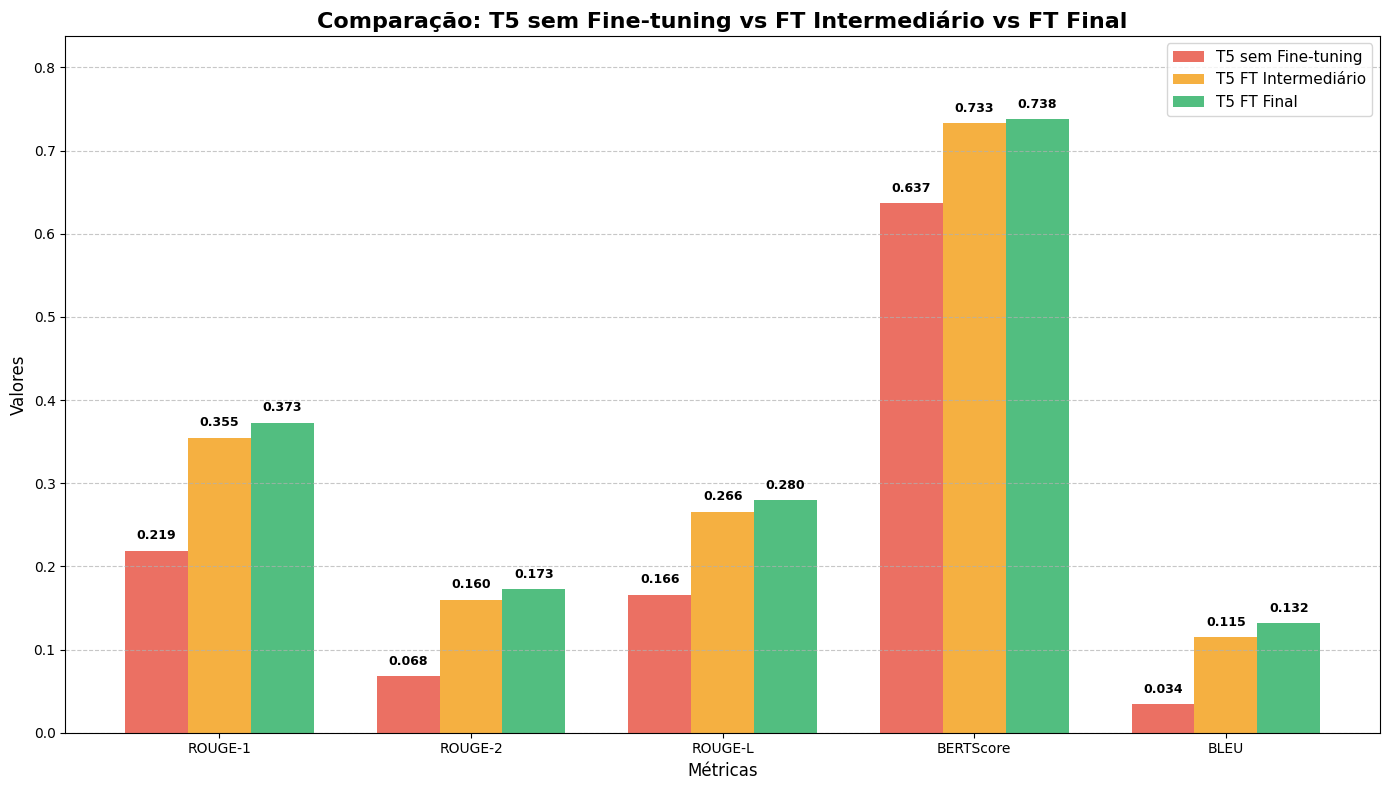

In [18]:
plt.figure(figsize=(14, 8))

# Valores das métricas
values_sem_ft = list(t5_sem_ft.values())
values_intermediario = list(t5_ft_intermediario.values())
values_final = list(t5_ft_final.values())
labels = list(t5_sem_ft.keys())

# Posições das barras
x = np.arange(len(labels))
width = 0.25

# Criando as barras
bars1 = plt.bar(x - width, values_sem_ft, width, label='T5 sem Fine-tuning',
                color='#E74C3C', alpha=0.8)  # Vermelho
bars2 = plt.bar(x, values_intermediario, width, label='T5 FT Intermediário',
                color='#F39C12', alpha=0.8)  # Laranja
bars3 = plt.bar(x + width, values_final, width, label='T5 FT Final',
                color='#27AE60', alpha=0.8)  # Verde

# Adicionando título e rótulos
plt.title('Comparação: T5 sem Fine-tuning vs FT Intermediário vs FT Final', fontsize=16, fontweight='bold')
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.xticks(x, labels)

# Adicionando valores nas barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Configurações do gráfico
plt.legend(fontsize=11)
plt.ylim(0, max(max(values_sem_ft), max(values_intermediario), max(values_final)) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

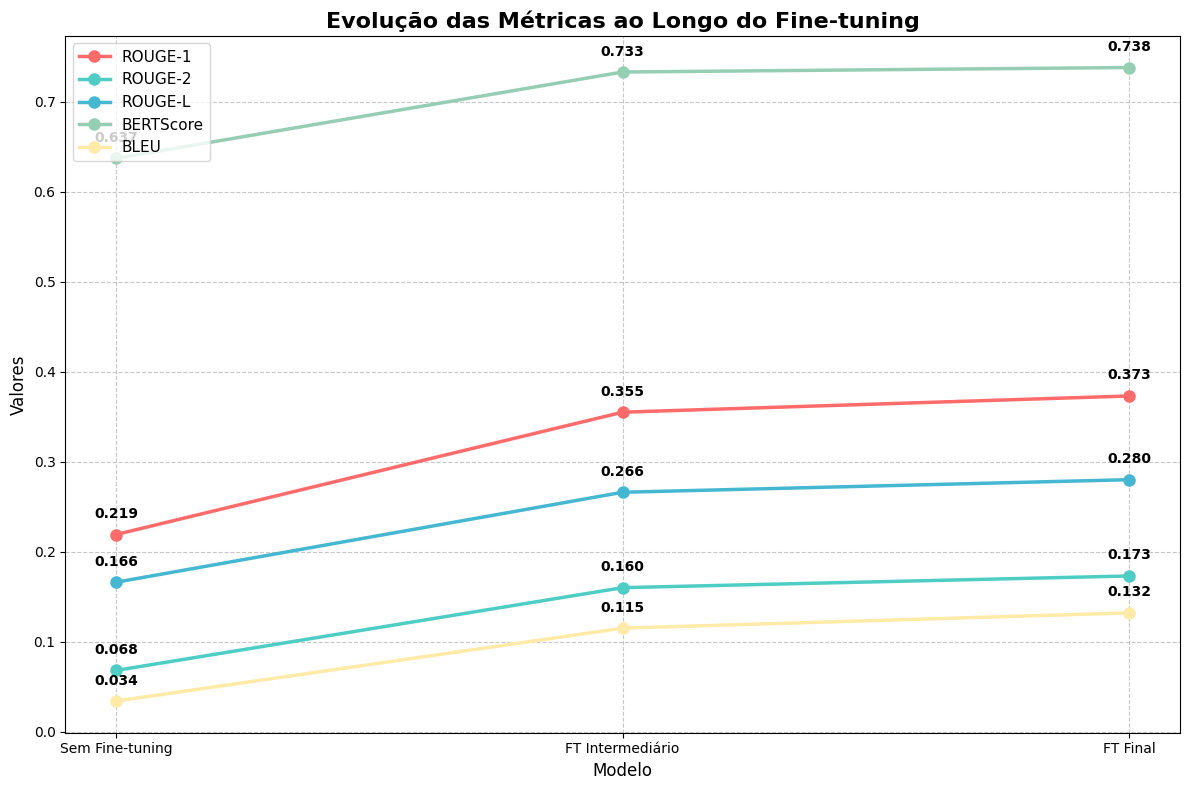

In [19]:
plt.figure(figsize=(12, 8))

# Dados para o gráfico de linha
modelos = ['Sem Fine-tuning', 'FT Intermediário', 'FT Final']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, metric in enumerate(labels):
    values = [t5_sem_ft[metric], t5_ft_intermediario[metric], t5_ft_final[metric]]
    plt.plot(modelos, values, marker='o', linewidth=2.5, markersize=8,
             label=metric, color=colors[i])

    # Adicionando valores nos pontos
    for j, v in enumerate(values):
        plt.text(j, v + 0.015, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('Evolução das Métricas ao Longo do Fine-tuning', fontsize=16, fontweight='bold')
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

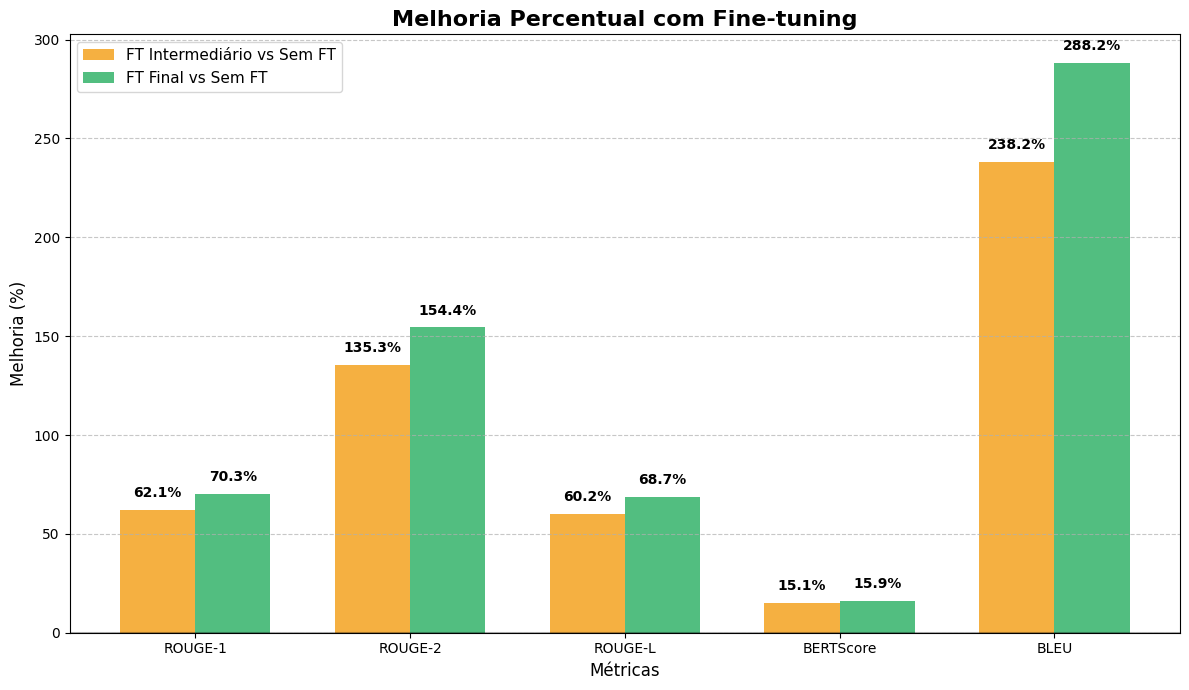

In [21]:
plt.figure(figsize=(12, 7))

# Calculando melhorias
melhoria_intermediario = [(t5_ft_intermediario[metric] - t5_sem_ft[metric]) / t5_sem_ft[metric] * 100
                          for metric in labels]
melhoria_final = [(t5_ft_final[metric] - t5_sem_ft[metric]) / t5_sem_ft[metric] * 100
                  for metric in labels]

# Posições das barras
x = np.arange(len(labels))
width = 0.35

# Criando as barras
bars1 = plt.bar(x - width/2, melhoria_intermediario, width, label='FT Intermediário vs Sem FT',
                color='#F39C12', alpha=0.8)  # Laranja
bars2 = plt.bar(x + width/2, melhoria_final, width, label='FT Final vs Sem FT',
                color='#27AE60', alpha=0.8)  # Verde

# Adicionando título e rótulos
plt.title('Melhoria Percentual com Fine-tuning', fontsize=16, fontweight='bold')
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Melhoria (%)', fontsize=12)
plt.xticks(x, labels)

# Linha horizontal em zero
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Adicionando valores nas barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [22]:
print("="*85)
print("COMPARAÇÃO COMPLETA: T5 SEM FINE-TUNING vs FT INTERMEDIÁRIO vs FT FINAL")
print("="*85)
print(f"{'Métrica':<12} {'Sem FT':<10} {'FT Inter':<10} {'FT Final':<10} {'Melh. Inter':<12} {'Melh. Final':<12}")
print("-"*85)

for metric in labels:
    sem_ft = t5_sem_ft[metric]
    ft_inter = t5_ft_intermediario[metric]
    ft_final = t5_ft_final[metric]

    melhoria_inter = ((ft_inter - sem_ft) / sem_ft) * 100
    melhoria_final = ((ft_final - sem_ft) / sem_ft) * 100

    print(f"{metric:<12} {sem_ft:<10.3f} {ft_inter:<10.3f} {ft_final:<10.3f} {melhoria_inter:<12.1f}% {melhoria_final:<12.1f}%")

print("="*85)


COMPARAÇÃO COMPLETA: T5 SEM FINE-TUNING vs FT INTERMEDIÁRIO vs FT FINAL
Métrica      Sem FT     FT Inter   FT Final   Melh. Inter  Melh. Final 
-------------------------------------------------------------------------------------
ROUGE-1      0.219      0.355      0.373      62.1        % 70.3        %
ROUGE-2      0.068      0.160      0.173      135.3       % 154.4       %
ROUGE-L      0.166      0.266      0.280      60.2        % 68.7        %
BERTScore    0.637      0.733      0.738      15.1        % 15.9        %
BLEU         0.034      0.115      0.132      238.2       % 288.2       %


In [23]:
print("\n" + "="*50)
print("RESUMO ESTATÍSTICO")
print("="*50)

# Médias
media_sem_ft = np.mean(list(t5_sem_ft.values()))
media_intermediario = np.mean(list(t5_ft_intermediario.values()))
media_final = np.mean(list(t5_ft_final.values()))

print(f"Média Sem Fine-tuning: {media_sem_ft:.3f}")
print(f"Média FT Intermediário: {media_intermediario:.3f}")
print(f"Média FT Final: {media_final:.3f}")

print(f"\nMelhoria média FT Intermediário: {((media_intermediario - media_sem_ft) / media_sem_ft * 100):.1f}%")
print(f"Melhoria média FT Final: {((media_final - media_sem_ft) / media_sem_ft * 100):.1f}%")
print(f"Melhoria FT Final vs Intermediário: {((media_final - media_intermediario) / media_intermediario * 100):.1f}%")
print("="*50)


RESUMO ESTATÍSTICO
Média Sem Fine-tuning: 0.225
Média FT Intermediário: 0.326
Média FT Final: 0.339

Melhoria média FT Intermediário: 44.9%
Melhoria média FT Final: 50.9%
Melhoria FT Final vs Intermediário: 4.1%
